In [1]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import pandas as pd

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import scipy
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [134]:
import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, Softmax
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import LeakyReLU
from keras.layers import Lambda
from keras.layers import concatenate

In [4]:
target_shape = (17, 22)

In [202]:
input_shape = (17, 22, 3)
alpha = 0.2

inputs = Input(shape=input_shape)

x = Conv2D(8, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3))(x)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(128)(x)
x = LeakyReLU(alpha)(x)

x = Dense(64)(x)
x = LeakyReLU(alpha)(x)

x = Dense(22)(x)

digit_type = Dense(2)(x)
left_digit = Dense(10)(x)
right_digit = Dense(10)(x)

digit_type = Softmax()(digit_type)
left_digit = Softmax()(left_digit)
right_digit = Softmax()(right_digit)




outputs = concatenate([digit_type, left_digit, right_digit])

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [203]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 17, 22, 3)    0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 15, 20, 16)   448         input_19[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_107 (LeakyReLU)     (None, 15, 20, 16)   0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_56 (MaxPooling2D) (None, 7, 10, 16)    0           leaky_re_lu_107[0][0]            
___________________________________________________________________________________________

In [230]:
dataframe = pd.read_csv("value_samples/labels.txt", delim_whitespace=True)

In [51]:
dataframe.iloc[0]

filename        sample_0.png
total_digits               2
left_digit                 0
right_digit                0
Name: 0, dtype: object

In [128]:
i, row = dataframe.iterrows().__next__()
print(row)

total_digits = row['total_digits']
left_digit = row['left_digit']
right_digit = row['right_digit']

label = np.zeros(22)
if total_digits == 2:
    label[0] = 1
    label[2+left_digit] = 1
else:
    label[1] = 1

label[2+10+right_digit] = 1

print(label)

filename        sample_0.png
total_digits               2
left_digit                 0
right_digit                0
Name: 0, dtype: object
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [231]:
class ImageGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size):
        self.samples = samples
        self.batch_size = batch_size
        
    @property
    def n(self):
        return len(self.samples)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, i):
        x = []
        y = []
        for filepath, label in self.samples[i*self.batch_size:(i+1)*self.batch_size]:
            image = cv2.imread(filepath)
            image = image / 255.0
            x.append(image)
            y.append(label)
        return (np.array(x), np.array(y))

In [232]:
def image_generator(dataframe, directory, batch_size, ratio=0.15):
    # validate filenames
    samples = []
    for i, row in dataframe.iterrows():
        filename = row['filename']
        total_digits = row['total_digits']
        left_digit = row['left_digit']
        right_digit = row['right_digit']
        
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath):
            continue
        
        label = np.zeros(22)
        if total_digits == 2:
            label[0] = 1
            label[2+left_digit] = 1
        else:
            label[1] = 1

        label[2+10+right_digit] = 1
        
        samples.append((filepath, label))
        
            
    np.random.shuffle(samples)
    
    print(f"Validated {len(samples)} files")
    
    total_validation = int(len(samples) * ratio)
    validation_samples = samples[:total_validation]
    training_samples = samples[total_validation:]
    
    return ImageGenerator(training_samples, batch_size), ImageGenerator(validation_samples, batch_size)

In [242]:
training_generator, validation_generator = image_generator(dataframe, "value_samples", 64)

Validated 9222 files


In [243]:
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
)

Epoch 1/10
122/122 [==============================] - 5s 41ms/step - loss: 2.4151 - accuracy: 0.9688 - val_loss: 2.5501 - val_accuracy: 0.9717
Epoch 2/10
122/122 [==============================] - 5s 37ms/step - loss: 2.4135 - accuracy: 0.9647 - val_loss: 2.5523 - val_accuracy: 0.9688
Epoch 3/10
122/122 [==============================] - 5s 38ms/step - loss: 2.4126 - accuracy: 0.9698 - val_loss: 2.5485 - val_accuracy: 0.9747
Epoch 4/10
122/122 [==============================] - 5s 37ms/step - loss: 2.4129 - accuracy: 0.9663 - val_loss: 2.5492 - val_accuracy: 0.9747
Epoch 5/10
122/122 [==============================] - 5s 38ms/step - loss: 2.4116 - accuracy: 0.9739 - val_loss: 2.5541 - val_accuracy: 0.9717
Epoch 6/10
122/122 [==============================] - 5s 38ms/step - loss: 2.4119 - accuracy: 0.9728 - val_loss: 2.5483 - val_accuracy: 0.9650
Epoch 7/10
122/122 [==============================] - 5s 38ms/step - loss: 2.4114 - accuracy: 0.9718 - val_loss: 2.5504 - val_accuracy: 0.9732

In [185]:
def prediction_to_digit(prediction):
    is_single_digit = np.argmax(prediction[0:2]) == 1
    
    left_digit = np.argmax(prediction[2:2+10])
    right_digit = np.argmax(prediction[2+10:2+10+10])

    if is_single_digit:
        return f"{right_digit}"
    else:
        return f"{left_digit}{right_digit}"

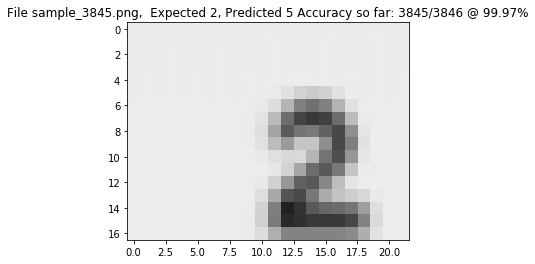

In [244]:
testing_dir = "value_samples"
testing_dataframe = pd.read_csv(f"{testing_dir}/labels.txt", delim_whitespace=True)

total_samples = 0
total_correct = 0

for i, row in testing_dataframe.iterrows():
    filename = row['filename']
    total_digits = row['total_digits']
    left_digit = row['left_digit']
    right_digit = row['right_digit']
    
    if total_digits == 1:
        digit = f"{right_digit}"
    else:
        digit = f"{left_digit}{right_digit}"
    
    filepath = f"{testing_dir}/{filename}"
    if not os.path.exists(filepath):
        continue

    image = cv2.imread(filepath)
    image = image/255

    prediction = model.predict(np.array([image]))[0]
    predicted_string = prediction_to_digit(prediction)
    
    total_samples += 1
    
    if predicted_string != digit:
        plt.title(f"File {filename},  Expected {digit}, Predicted {predicted_string} "+
                  f"Accuracy so far: {total_correct}/{total_samples} @ {total_correct/total_samples * 100:.2f}%")
        plt.imshow(image)
        plt.show()
    else:
        total_correct += 1

In [245]:
model.save("two_digit_classifier.h5")

In [246]:
model.save("../assets/models/two_digit_classifier.h5")